## Fast Gradient Sign Method Attack

Adverserial attack aims at misleading, evading or decieving a machine learning model by introducing small and often imperceptible  perturbations (noise). One of the most known attack for image classification tasks is known as **Fast Gradient Sign Method (FGSM)**.The attack aims at introducing peturbation that optimize the input data to maximize the prediction error of a model. 

FGSM is done to introducing a noise along **the direction of the sign of the gradient at _each pixel_**. In other words, the noises are closely aligned with the weight vectors a model is attempting to generlize. Its important to note that the attack simply emulates the **sign** of the elements of the gradient.

In the following example, we will demonestrate FGSM attack using the ImageNet Dataset and a pretrianed model using the ReseNet50 architecture. The sample code is written using the python library **foolbox**.
    
  

#### modules and model

In [1]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.


Let's start by insantiating the model and introducing a preprocessing task.

In [2]:
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.



Next up, we will use a sample image and its label from the imagenet dataset.

In [3]:
from PIL import Image

filename = './data/warplane2.jpg'
label=895 # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

original = load_img(filename, target_size=(224, 224))
numpy_image = img_to_array(original)
original_img_batch = np.expand_dims(numpy_image, axis=0)

print('image batch size', original_img_batch.shape)


image batch size (1, 224, 224, 3)


#### Plot original image

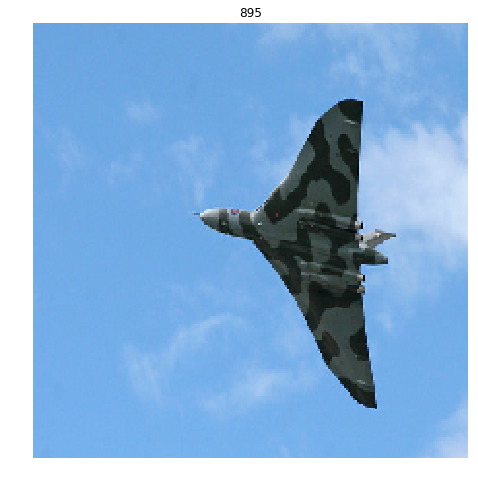

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(np.uint8(original_img_batch[0]))
plt.title(label)
plt.axis('off')
plt.show()

### Prediction on the original image

In [6]:
orignal_img_prediction = kmodel.predict_on_batch(original_img_batch)
original_img_label = decode_predictions(orignal_img_prediction )

print(original_img_label[0])

[('n04552348', 'warplane', 0.8916511), ('n04592741', 'wing', 0.05332023), ('n04266014', 'space_shuttle', 0.023437275), ('n04008634', 'projectile', 0.011651035), ('n02690373', 'airliner', 0.006808288)]


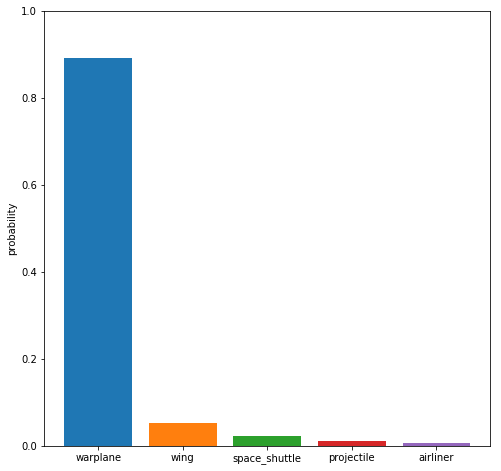

In [7]:
plt.figure(figsize=(8,8))
for i in enumerate(original_img_label[0]):
    name,org_score = i[1][1:3]
    plt.bar(name,org_score)
    plt.ylim(0,1)
    plt.ylabel('probability')
    

The model classified the image as a warplane with 89% confidence.

### Applying the Attack

Steps:
    - First, call the FGMS attack
    - Second, get the gradient of the model 
    - Third, introduce the attack to the image.


In [8]:
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(numpy_image[:, :, ::-1], epsilons=2000, label=895)

The default value of the attack uses an iterable step sizes of **1000**. This is number of steps the attack iterates in the direction of the sign of the gradient. 

**::-1** is added to reverse the color channels of the image, because Keras ResNet50 expects BGR instead of RGB. 

Let's take a look at the perturbation introduced by the attack.

In [9]:
difference = adversarial[:, :, ::-1] - numpy_image
difference[0:1,0:14]

array([[[-1.4024963, -1.4024963, -1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [ 1.4024963, -1.4024963, -1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [-1.4024963,  1.4024963, -1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [ 1.4024963, -1.4024963,  1.4024963],
        [-1.4024963, -1.4024963, -1.4024963]]], dtype=float32)

The array shown above is the first 15 values added to the original image by the attack to create an adverserial example. To visualize the values, a little bit of agumentation is needed.

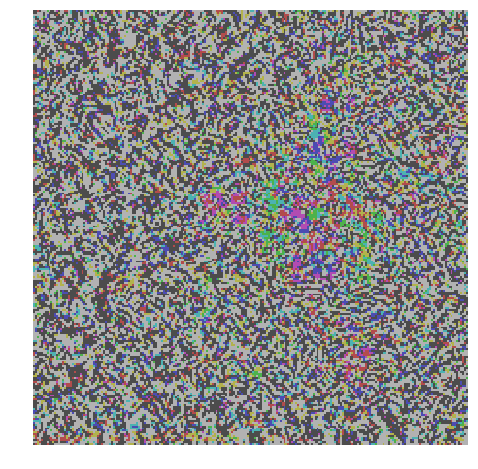

In [10]:
plt.figure(figsize=(8,8))
agumentated_adv = difference / abs(difference).max() * 0.2 + 0.5
plt.imshow(agumentated_adv)
plt.axis('off')
plt.show()

#### Plot the adversarial example

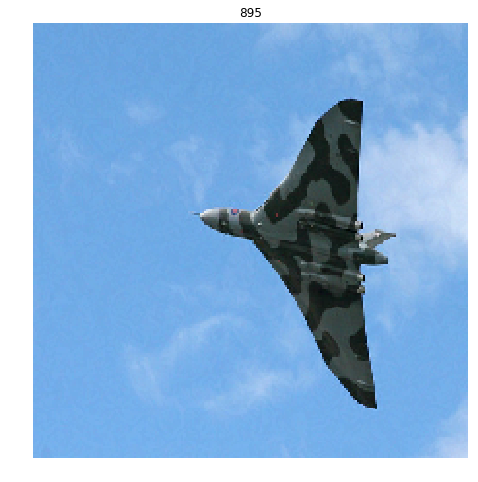

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(adversarial[:, :, ::-1]/255)
plt.title(label)
plt.axis('off')
plt.show()

### Side by side view

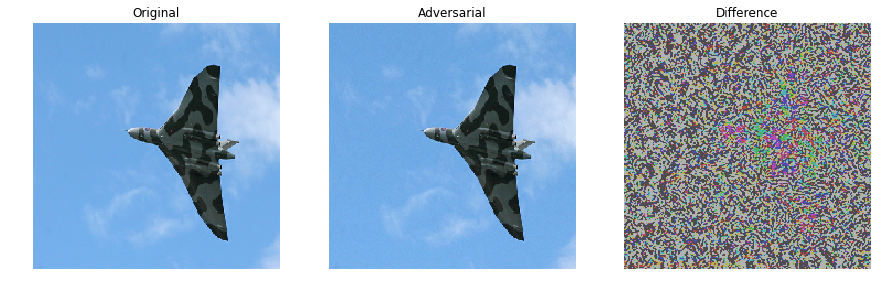

In [12]:
%matplotlib inline

plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(numpy_image / 255) 
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - numpy_image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

 ### Prediction on the adversarial

Let's use the imagenet model and predict on both the original image and the adverserial example. 
First, change each of the images to a batch format.

In [14]:
advesarial_img_batch = np.expand_dims(adversarial, axis=0)
advesarial_img_prediction = kmodel.predict_on_batch(advesarial_img_batch)
advesarial_img_label = decode_predictions(advesarial_img_prediction)
print(advesarial_img_label)

[[('n04552348', 'warplane', 0.45305192), ('n04266014', 'space_shuttle', 0.12352038), ('n02687172', 'aircraft_carrier', 0.08194003), ('n04592741', 'wing', 0.070094444), ('n04044716', 'radio_telescope', 0.06527093)]]


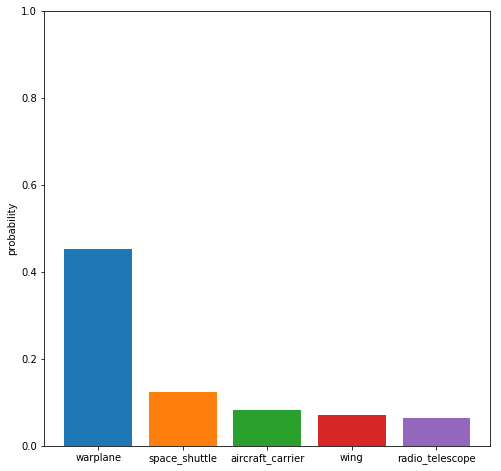

In [16]:
plt.figure(figsize=(8,8))
adv_score_table = []
for i in enumerate(advesarial_img_label[0]):
    name,adv_score = i[1][1:3]
    adv_score_table.append(name)
    adv_score_table.append(adv_score)
    plt.bar(name, adv_score)
    plt.ylim(0,1)
    plt.ylabel('probability')
    

Accordingly, the probability is now down to 45%. that's a 50% decline in confidence.

### References:
    